<a href="https://colab.research.google.com/github/MUHAMMADALYAN/Sequences-Time-Series-and-Prediction/blob/master/Using_Real_time_Sunspot_Time_Series_with_Conv%2CLSTM%2CDense_NN_for_predicting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# We will try to optimize loss by tuning window , batch filter sizes etc

In [0]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

### Getting sun spot data from kaggle wth 3 colums index,date,sunpot seen mean

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-06-04 22:14:35--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-06-04 22:14:35 (108 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



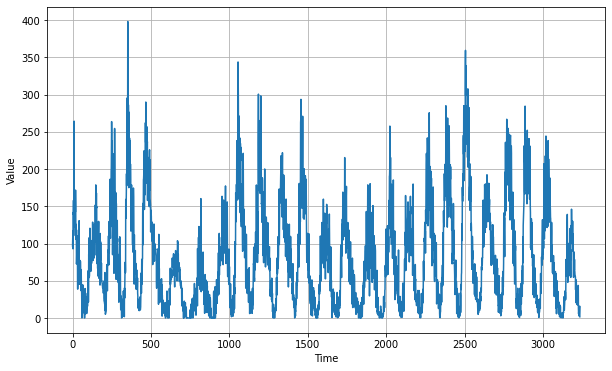

In [0]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))# getting sunspots mean per month
    time_step.append(int(row[0])) #   here 1 time stamp=1 month so window size of 20=20 months

series = np.array(sunspots) # coverting to numpy as it is efficent  
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

## Splitting data 

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) # Expanding dimension to be used 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True) #windowing data
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Try training with different window sizes and batch sizes

 ### here 1 time stamp=1 month so window size of 64=64 months 
 
### but our seasonality is greater than 2 years and it is 11 years 135 months approximatly next we cahnge window size to 135 next time but it has not any better effect

so we should cahnge size of our training data e.g 2500

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64 
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 0s 28ms/step - loss: 79.8340 - mae: 80.3314 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 0s 26ms/step - loss: 78.0944 - mae: 78.5918 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 0s 26ms/step - loss: 75.4519 - mae: 75.9497 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 0s 25ms/step - loss: 72.2679 - mae: 72.7658 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 0s 27ms/step - loss: 68.7693 - mae: 69.2672 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 0s 24ms/step - loss: 65.1128 - mae: 65.6099 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 0s 28ms/step - loss: 61.5272 - mae: 62.0241 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 0s 25ms/step - loss: 58.1406 - mae: 58.6369 - l

(1e-08, 0.0001, 0.0, 60.0)

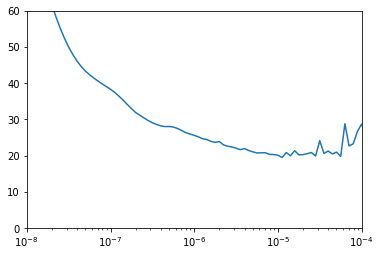

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 0s 14ms/step - loss: 38.9172 - mae: 39.4135
Epoch 2/500
30/30 [==============================] - 0s 14ms/step - loss: 25.7615 - mae: 26.2559
Epoch 3/500
30/30 [==============================] - 0s 15ms/step - loss: 22.0765 - mae: 22.5702
Epoch 4/500
30/30 [==============================] - 0s 14ms/step - loss: 20.4691 - mae: 20.9620
Epoch 5/500
30/30 [==============================] - 0s 14ms/step - loss: 19.7103 - mae: 20.2028
Epoch 6/500
30/30 [==============================] - 0s 16ms/step - loss: 19.2554 - mae: 19.7476
Epoch 7/500
30/30 [==============================] - 0s 15ms/step - loss: 18.6502 - mae: 19.1421
Epoch 8/500
30/30 [==============================] - 0s 15ms/step - loss: 18.2062 - mae: 18.6978
Epoch 9/500
30/30 [==============================] - 0s 14ms/step - loss: 18.0970 - mae: 18.5886
Epoch 10/500
30/30 [==============================] - 0s 15ms/step - loss: 19.9600 - mae: 20.4519
Epoch 11/500
30/30 [=========

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

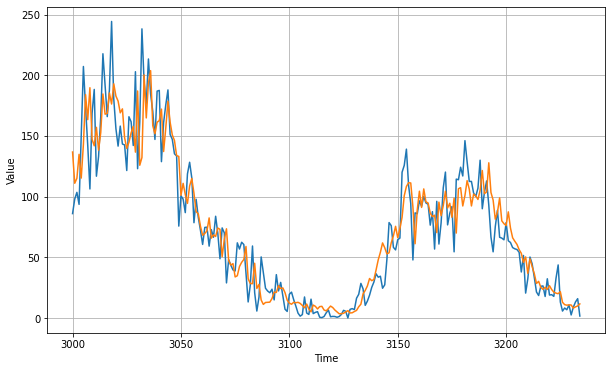

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.106703

<Figure size 432x288 with 0 Axes>

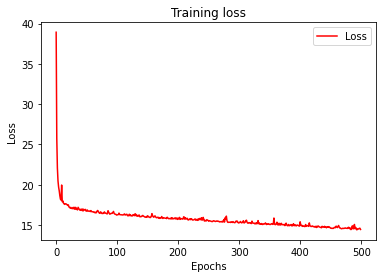

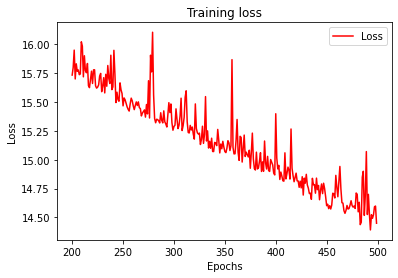

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [0]:
print(rnn_forecast)

[136.7189    110.98249   115.122284  134.82281   115.25641   143.04535
 184.01285   163.3962    189.70985   147.21992   141.86137   157.0715
 138.28636   152.78816   184.56857   167.90044   168.60675   185.33456
 176.27847   192.90251   182.82016   178.76093   169.03139   172.28322
 148.60156   139.66159   144.71025   152.50296   157.8594    136.6324
 187.00734   125.82245   132.20448   200.31174   164.82422   193.6641
 203.79118   158.3843    151.77454   161.31116   162.59613   172.08882
 137.1343    156.6563    178.58672   161.35086   150.87347   146.24599
 133.75977   133.12578   101.03011   110.90815   101.75661    94.40413
 108.75657   114.939835  102.75052    87.56627    85.79521    75.54211
  68.153755   69.60501    71.84579    82.44467    65.77282    68.490944
  67.14471    74.09004    73.04694    50.49032    64.71024    73.47204
  47.39887    43.61073    44.772194   33.81348    34.808712   42.42825
  45.85957    48.184593   58.92176    32.223858   28.433737   28.25356
  45.097

## Trying filters ,cells , window size  mutilply such that divide 3000 training examples

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
30/30 [==============================] - 0s 14ms/step - loss: 38.9172 - mae: 39.4135
Epoch 2/150
30/30 [==============================] - 0s 15ms/step - loss: 25.7615 - mae: 26.2559
Epoch 3/150
30/30 [==============================] - 0s 15ms/step - loss: 22.0765 - mae: 22.5702
Epoch 4/150
30/30 [==============================] - 0s 14ms/step - loss: 20.4695 - mae: 20.9624
Epoch 5/150
30/30 [==============================] - 0s 15ms/step - loss: 19.7061 - mae: 20.1986
Epoch 6/150
30/30 [==============================] - 0s 16ms/step - loss: 19.2530 - mae: 19.7452
Epoch 7/150
30/30 [==============================] - 0s 15ms/step - loss: 18.6528 - mae: 19.1448
Epoch 8/150
30/30 [==============================] - 0s 15ms/step - loss: 18.1652 - mae: 18.6568
Epoch 9/150
30/30 [==============================] - 0s 14ms/step - loss: 18.1267 - mae: 18.6181
Epoch 10/150
30/30 [==============================] - 0s 15ms/step - loss: 20.0240 - mae: 20.5161
Epoch 11/150
30/30 [=========

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

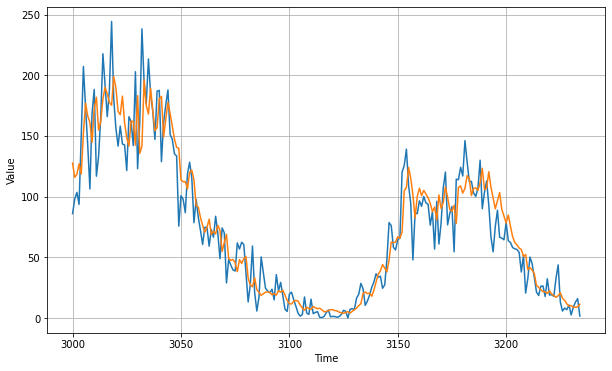

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.430475

In [0]:
print(rnn_forecast)

[127.619446  115.88743   118.33863   127.01527   118.65391   152.12286
 176.88162   166.38898   161.18028   144.64517   172.80794   181.88693
 154.72923   161.74161   180.59824   189.99559   184.6447    177.61832
 175.30022   198.85962   189.52821   170.07996   167.49994   182.7808
 160.84879   148.34825   141.52031   162.3076    161.86018   142.3583
 183.1824    135.58319   141.6516    196.33984   175.15071   168.06607
 189.22508   171.10703   154.2836    157.05405   180.64638   182.53459
 149.08612   163.7585    177.56071   168.61952   157.94168   147.42712
 140.55974   139.81114   113.88467   112.25378   112.271324  106.32725
 120.07866   121.797874  113.835815   92.62949    91.29797    82.78452
  76.29875    70.58091    74.55222    81.35204    68.69536    71.509636
  69.30004    76.29747    72.33473    54.82519    62.16421    68.94052
  49.060284   47.474297   48.179523   45.43148    38.20907    48.013283
  44.931942   49.00004    50.6425     32.739906   27.337166   25.669765
  33.

<Figure size 432x288 with 0 Axes>

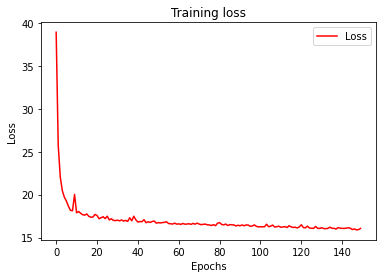

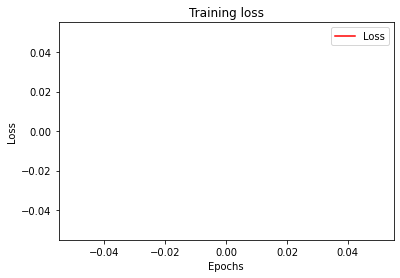

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = epochs[200:]


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()